# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [17]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### Extract the data from several csv files and concatenate them

In [3]:
def extraction_ebola(directory_name, country_name):
    
    files = [fn for fn in glob.glob(directory_name)]
    df_from_each_file = (pd.read_csv(f) for f in files)
    df = pd.concat(df_from_each_file, ignore_index=True)

    ##### Adding the Country name to the data frame
    country = [country_name] * len(df)
    country_df = pd.DataFrame({'country': country})
    df.join(country_df)
    
    return df
   
guinea_df = extraction_ebola('Data/ebola/guinea_data/*', 'Guinea')
liberia_df = extraction_ebola('Data/ebola/liberia_data/*', 'Liberia')
sierra_leone_df = extraction_ebola('Data/ebola/sl_data/*', 'Sierra Leone')

### Keep only the new cases and new deaths

We first begin by characterize the different strings that are present in the csv files. This part could become necessary if ones want to add simply a new country to analyze. 

We first define in the _'countrystring'_ series the names of the different columns necessary. The _'search'_ series define the description that are interesting in our analysis, and the _'todrop'_ defines the ones that won't be kept. For the moment, our analysis revolves exclusively around the confirmed cases and deaths, while ignoring the other ones. As we have no information, we have no idea of the constitency between the countries of those observations, it appears as they might not represent the correct effects ot Ebola. 

In [21]:
## STRINGS CHARACTERIZATION
Months = ['January','February','March','April','May','June','July','August','September','October','November','December']

# Name of all columns in each csv files
guinea_string = ['Date','Description','Totals','New cases','New deaths registered today']
sierra_string = ['date','variable','National','new_confirmed','death_confirmed']
liberia_string = ['Date','Variable','National','New case/s','Newly reported deaths']

# Search queries, and terms to drop
search_cases = ['New cases of confirmed', 'New case/s', 'new_confirmed']
search_deaths = ['New deaths registered','Newly reported deaths','death_confirmed']
to_drop_cases = ['health']
to_drop_deaths = ['health','probables', 'confirmed', 'suspects']

In [ ]:
## TABLES PREPARATION
# New Cases
cases_guinea = guinea_df[guinea_df[guinea_string[1]].str.contains('|'.join(search_cases))]
cases_liberia = liberia_df[liberia_df[liberia_string[1]].str.contains('|'.join(search_cases))]
cases_sl = sierra_leone_df[sierra_leone_df[sierra_string[1]].str.contains('|'.join(search_cases))]

# New Deaths
deaths_guinea = guinea_df[guinea_df[guinea_string[1]].str.contains('|'.join(search_deaths))]
deaths_liberia = liberia_df[liberia_df[liberia_string[1]].str.contains('|'.join(search_deaths))]
deaths_sl = sierra_leone_df[sierra_leone_df[sierra_string[1]].str.contains('|'.join(search_deaths))]

# Filter unwanted lines
cases_guinea = cases_guinea[~cases_guinea[guinea_string[1]].str.contains('|'.join(to_drop_cases))]
deaths_guinea = deaths_guinea[~deaths_guinea[guinea_string[1]].str.contains('|'.join(to_drop_deaths))]

# Delete NaN values
cases_guinea = cases_guinea[pd.notnull(cases_guinea[guinea_string[2]])]
deaths_guinea = deaths_guinea[pd.notnull(deaths_guinea[guinea_string[2]])]

cases_sl = cases_sl[pd.notnull(cases_sl[sierra_string[2]])]
deaths_sl = deaths_sl[pd.notnull(deaths_sl[sierra_string[2]])]

cases_liberia = cases_liberia [pd.notnull(cases_liberia [liberia_string[2]])]
deaths_liberia = deaths_liberia [pd.notnull(deaths_liberia [liberia_string[2]])]

In [22]:
## Just for testing purpose
#cases_guinea['Totals']

guinea_date = pd.to_datetime(cases_guinea['Date'])
toSum = guinea_date[guinea_date.dt.month == 8]

hr2006 = cases_guinea.loc[guinea_date.dt.month == 10, 'Totals']
hr2006 = hr2006.reset_index(drop=True)
numbers  = [ int(x) for x in hr2006 ]
sum(numbers)
hr2006.shape

(1,)

We define a function 'day_average_per_month' that returns for a given country an array _cases_ containing the daily average for each month. The function takes as input the DataFrame of the country plus the previously define string containing the names of the columns. In a for loop, every month is passed onto review, the number of corresponding cases is summed. The total is then divided by the number of days where a measurement was made. 

The choice to not divide by the number of days in the month but by this observation comes from the lack of informations we have on the csv file. We don't know if the missing days corresponds to a lack of information, or that when a new file is created the new_cases and new_deaths values are counted from the previous measurement.

In [23]:
# Function to count number of cases per month + number of entries
def day_average_per_month(country_df, country_string):
    
    #Conversion to be able to extract the month from the date columns
    country_date = pd.to_datetime(country_df[country_string[0]])
    cases = []
    
    #Calculation for each month
    for i in range(1,13):
        #Creation of a new table with only the totals from the current month
        toSum = country_df.loc[country_date.dt.month == i,country_string[2]]
        toSum = toSum.reset_index(drop=True)
        
        #Summing all values for the month
        daily_cases  = [ int(x) for x in toSum]
        month_sum = sum(daily_cases)
        
        # Let's avoid to divide by 0
        if toSum.shape[0] == 0:
            day_average = 0
        # Day average calculated as the total sum of the month divided by the number of days that were registered    
        else:
            day_average = month_sum/float(toSum.shape[0])
            
        print day_average
        cases.append(day_average)
        
    return cases

0
0
0
0
0
0
0
12.4
13.0
6.0
0
0


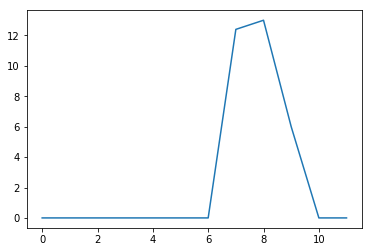

In [24]:

cases = day_average_per_month(cases_guinea, guinea_string)
plt.plot(cases)
plt.show()

#deaths_guinea = guinea_df[guinea_df['D'].str.contains('|'.join(search_deaths))]

## Discussion

Lorem ipsum...

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [ ]:
# Write your answer here

### Extraction of the spreadsheets

In [ ]:
def extraction_microbiome(directory_name, exclude_file):
    
    files = [fn for fn in glob.glob(directory_name) if not os.path.basename(fn).startswith(exclude_file)]
    df_from_each_file = (pd.read_excel(f, names = ['name', 'number']) for f in files)
    df = pd.concat(df_from_each_file, ignore_index=True)
    
    return df

In [ ]:
MID = extraction_microbiome('Data/microbiome/*.xls', 'metadata')

### Addition of the information from metadata.xls

In [ ]:
## Extraction microbiome n'est en fait pas une solution optimale. Pour ajouter les metadata par la suite il faut 
# la taille de chaque fichier Excel. 

### Second method

In [ ]:
MID1 = pd.read_excel('Data/microbiome/MID1.xls', names = ['name', 'number'])
MID2 = pd.read_excel('Data/microbiome/MID2.xls', names = ['name', 'number'])
MID3 = pd.read_excel('Data/microbiome/MID3.xls', names = ['name', 'number'])
MID4 = pd.read_excel('Data/microbiome/MID4.xls', names = ['name', 'number'])
MID5 = pd.read_excel('Data/microbiome/MID5.xls', names = ['name', 'number'])
MID6 = pd.read_excel('Data/microbiome/MID6.xls', names = ['name', 'number'])
MID7 = pd.read_excel('Data/microbiome/MID7.xls', names = ['name', 'number'])
MID8 = pd.read_excel('Data/microbiome/MID8.xls', names = ['name', 'number'])
MID9 = pd.read_excel('Data/microbiome/MID9.xls', names = ['name', 'number'])

frames = [MID1, MID2, MID3, MID4, MID5, MID6, MID7, MID8, MID9]
MID_df = pd.concat(frames)

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [ ]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [ ]:
# Write your answer here